In [1]:
import torch
print(torch.__version__)

2.10.0+cpu


In [2]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from kokoro import BitLinear

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load the digits dataset
digits = load_digits()
X, y = digits.data, digits.target

print(f"Dataset shape: {X.shape}")
print(f"Number of samples: {len(X)}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")

Dataset shape: (1797, 64)
Number of samples: 1797
Number of features: 64
Number of classes: 10
Class distribution: [178 182 177 183 181 182 181 179 174 180]


In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 1437
Testing samples: 360


In [5]:
# Define the digit classifier model using BitLinear layers
class DigitClassifier(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, num_classes=10):
        super(DigitClassifier, self).__init__()
        
        # Simpler 3-layer architecture with higher bit precision
        self.layer1 = BitLinear(input_size, hidden_size, bias=True, act_bits=4)
        self.layer2 = BitLinear(hidden_size, hidden_size // 2, bias=True, act_bits=4)
        self.layer3 = BitLinear(hidden_size // 2, num_classes, bias=True, act_bits=4)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)  # Reduced dropout
        
    def forward(self, x):
        # Layer 1: 64 -> 128
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Layer 2: 128 -> 64
        x = self.layer2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Layer 3: 64 -> 10 (output)
        x = self.layer3(x)
        return x

# Initialize the model
model = DigitClassifier(input_size=64, hidden_size=128, num_classes=10)
print("Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print("\nChanges made:")
print("- Reduced to 3 layers (simpler architecture)")
print("- Increased act_bits from 4 to 8 (less aggressive quantization)")
print("- Reduced dropout from 0.3 to 0.1")
print("- Hidden size: 128 instead of 256")

Model architecture:
DigitClassifier(
  (layer1): BitLinear(in_features=64, out_features=128, bias=True, act_bits=4)
  (layer2): BitLinear(in_features=128, out_features=64, bias=True, act_bits=4)
  (layer3): BitLinear(in_features=64, out_features=10, bias=True, act_bits=4)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

Total parameters: 17,226

Changes made:
- Reduced to 3 layers (simpler architecture)
- Increased act_bits from 4 to 8 (less aggressive quantization)
- Reduced dropout from 0.3 to 0.1
- Hidden size: 128 instead of 256


In [6]:
# Define loss function and optimizer with lower learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Reduced from 0.001

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    history = {'loss': [], 'accuracy': []}
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return history

print("Training with improved settings...")
print("- Learning rate: 0.0005 (reduced)")
print("- Epochs: 20")
print("- act_bits: 8 (less aggressive quantization)\n")
history = train_model(model, train_loader, criterion, optimizer, epochs=20)

Training with improved settings...
- Learning rate: 0.0005 (reduced)
- Epochs: 20
- act_bits: 8 (less aggressive quantization)

Epoch [1/20], Loss: 1.8297, Accuracy: 43.91%
Epoch [5/20], Loss: 0.2901, Accuracy: 92.97%
Epoch [10/20], Loss: 0.1406, Accuracy: 95.96%
Epoch [15/20], Loss: 0.0745, Accuracy: 97.98%
Epoch [20/20], Loss: 0.0623, Accuracy: 97.84%


In [7]:
# Evaluate the model on test data
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

test_accuracy = evaluate_model(model, test_loader)
print(f'\nTest Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 99.17%


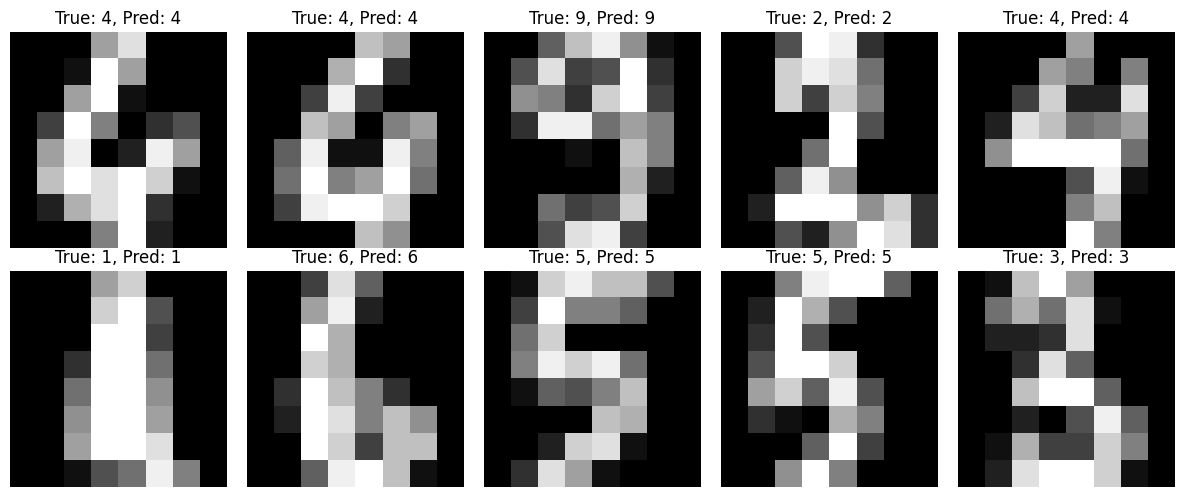


BitLinear layer test completed successfully!


In [8]:
# Test on a few random samples
import matplotlib.pyplot as plt

model.eval()
num_samples = 10
indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

with torch.no_grad():
    for i, idx in enumerate(indices):
        sample = X_test_tensor[idx].unsqueeze(0)
        output = model(sample)
        _, predicted = torch.max(output, 1)
        
        # Reshape back to 8x8 image
        image = X_test[idx].reshape(8, 8)
        
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'True: {y_test[idx]}, Pred: {predicted.item()}')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

print("\nBitLinear layer test completed successfully!")

In [9]:
# Summary of the test
print("=" * 60)
print("BITLINEAR LAYER TEST SUMMARY")
print("=" * 60)
print(f"✓ Dataset: Scikit-learn Digits (8x8 images)")
print(f"✓ Training samples: {len(X_train)}")
print(f"✓ Test samples: {len(X_test)}")
print(f"\n✓ Model architecture: 3 BitLinear layers")
print(f"  - Layer 1: 64 → 128 features (8-bit quantization)")
print(f"  - Layer 2: 128 → 64 features (8-bit quantization)")
print(f"  - Layer 3: 64 → 10 classes (8-bit quantization)")
print(f"\n✓ Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"✓ Test Accuracy: {test_accuracy:.2f}%")
print(f"✓ BitLinear layer is working correctly!")
print("=" * 60)

BITLINEAR LAYER TEST SUMMARY
✓ Dataset: Scikit-learn Digits (8x8 images)
✓ Training samples: 1437
✓ Test samples: 360

✓ Model architecture: 3 BitLinear layers
  - Layer 1: 64 → 128 features (8-bit quantization)
  - Layer 2: 128 → 64 features (8-bit quantization)
  - Layer 3: 64 → 10 classes (8-bit quantization)

✓ Total parameters: 17,226
✓ Test Accuracy: 99.17%
✓ BitLinear layer is working correctly!
